In [1]:
from Bio import SeqIO
import pandas as pd
from scipy import stats
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

In [2]:
seqdict = {}
for record in SeqIO.parse('/Users/jonwells/Desktop/Daes.fa', 'fasta'):
    seqdict[record.id] = str(record.seq)

In [3]:
seqlens = [(key, len(val)) for key, val in seqdict.items()]
length_df = pd.DataFrame(seqlens, columns=['name', 'length'])
print(length_df.head())

                      name  length
0   Danio_aesculapii_g5.t1     321
1   Danio_aesculapii_g9.t1     293
2  Danio_aesculapii_g10.t1     265
3  Danio_aesculapii_g15.t1     358
4  Danio_aesculapii_g16.t1     349


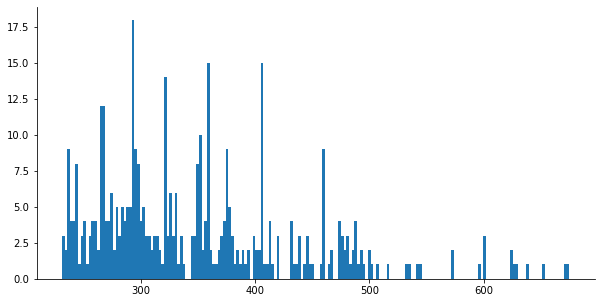

In [4]:
fig, ax = plt.subplots(figsize=(10, 5))
# ax.set_yscale('log')
plt.hist(length_df.length, bins=len(set(length_df.length)))
sns.despine()
plt.show()